## StarCraft II<br>Understanding adversarial human behaviour in games of skill and information asymmetry.

### by Mycchaka Kleinbort

<right><img src="./Images/AI_timeline.png" style=" margin: 5px; width: 1080px"></right>

## Introduction

Checkers, Chess, Backgamon, Jeperdy, Go..

It is perhaps inevitable that any game played by humans will eventualy become the subject of ongoing A.I. research. The framework of games - rules and objectives - is inherently suited to systematic study, and their ever increasing complexity has motivated a seemingly endless stream of new tools and insights.

In November of 2016 Google DeepMind - in partnership with Blizzard entertainment - anounced their intention to make Starcraft 2 the focus of further A.I. research. In this project we seek to compile and explore the currently available data, to extract and infer features that can qualify a player's performance, and to validate these features by building several predictive models.


## Index
- [Introduction](#intro)
- [Objectives](#objectives)
    - [Principal objective](#objectives1)
    - [Auxiliary objectives](#objectives2)
    - [Challenges](#challenges)
    
- [Introduction to StarCaft 2](#introSC2)
    - [Units](#units)
    - [The replay file format](#replay)


[](#objectives)
## Objectives

>The game lasted for 73 moves but eventually Deep Blue's operator had to resign the game for the computer in a position where both players had a bishop but Kasparov had three pawns to Deep Blue's one.
<br>
><div style="color:gray ; text-align: left">_Kasparov vs Deep Blue - Game 2, 1996_</div>

A game of StarCraft II ends when all building and units of all but one player have been destroyed. At low skill levels players often go through the motions of torching every house and eliminating every larva till the game engine grants them victory. However, much like in chess, experienced players know when it's over and conceed the match. This ability to distinguish between a dificult situation and a hopless one is admirable and as of yet utterly beyond thecapabilities of the game's AI - it is also the focus of this project. We hope that through exploring this aspect of the game, several interesting metrics for a player's performance will come to light - it would be a separate project to incorporate these metrics into a fittness function for an agent's performance.

### Principal objective

$\mathbb{f} : \text{Possible Game States} \rightarrow [0,1]$

Our main goal is to build a predictive model $\mathbb{m}$ that can predict a player's eventual surrender based on the game's current state. Formaly this will be a classification model that will take as input the game state from the perspective of a player and predict weather they will eventually surrender or win the game.

Intuition tells us that this model will be capable predicting the winner with increasing certainty as the game progresses, but it is important to note that attaining an accuracy above 50% will be a significant challenge. The very premise of our data is that games end when the winner becomes apparent to the loosing player, meaning that to any improvement upon the baseline will mean our model is more preceptive than a player who has spent thousands of hours developing their expertice. 

Furthermore, by examining what probabilities our model assigns to each category on a given input we will have a function that will be a very interesting jumping point for further analysis:

    f(player, Game State at T) = P(player eventualy concedes | GameState at T)
    
Hopefully this function will allow us to percieve:
   - games where a player's advantage is becoming ever more entrenched.
   - games where the player manages to overcome a dificult situation.
   - games where the odds of each player change dramatically due to one battle or choice. 

### Preliminar objective

Our task above has a very clear 'simplest case': To predict who surrendered at the moment the game ended.

Our first efforts are directed towards attaining a reasonably accurate model capable of predicting who was the winner given the final game state.


### Auxiliary objectives 
$\mathbb{r} : \text{Possible Game States} \rightarrow \mathbb{R}_{+}$<br>
$\mathbb{h} : \text{Possible Game States} \rightarrow \mathcal{C}_{0}(\mathbb{R}_{+})$

We will also seek to investigate the relationship between the current game state and the time until the game terminates.

Explicitly, we seek to build a regression model $\mathbb{r}$ that will predict the time remaining based on a the current game state. 

    r(Game State at T) = Game Length - T

By examining our mode's predictions and their residues we hope to build a function:

    h(Game State at T) = pdf(Game ends at t > T | Game State at T)
    

### Challenges

In our task at hand we will face several areas of dificulty. Namely:

   - StarCraft 2 is being constantly updated, with tweeks being roled out weekly and sweeping changes occuring fairly regularly.
   - Players can choose any of 3 different races, each with very distinct playstyles and counterplay oportunities - this efectively fragments any data we have into 9 matchups.
   - Games are played across a large variety of maps - each with their own viable strategies and exploits - and even within each map starting locations are somewhat randomized.
   - Games can be played with all manner of team configurations and with all maner of custom rule sets.
       
We mitigate these issues is by restricting our attention exclusively to:
   - 1v1 games
   - played under the latest major update to the game (LotV)
   - in maps that have been part of the ladder rotation
   - with the default competitive ruleset.

In [13]:
# Imports and configurations
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from ipywidgets import Checkbox, IntSlider

import matplotlib as mpl
import pickle

from Scripts.mklib import plist 

import sc2reader
from sc2reader.engine.plugins import APMTracker, SelectionTracker
sc2reader.engine.register_plugin(APMTracker())
sc2reader.engine.register_plugin(SelectionTracker())

In [14]:
# Setting plotting options
sns.set_palette([
 (0.30, 0.45, 0.69),
 (0.33, 0.66, 0.41),
 (0.77, 0.31, 0.32),
 (0.80, 0.73, 0.45),
 (0.39, 0.71, 0.80)])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 14,
         'axes.labelsize': 14,
         'axes.titlesize':20}
pylab.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('seaborn-white')

pd.options.display.max_columns = 150

## Introduction to StarCraft II


### SC2 - the game
StarCraft 2 is an increadibly popular videogame by Blizzard Entertainment in the RTS genre. The game places each player in the role of comanding officer with the ability to issue instructions to individual units under their command. Over the course of a match, each player must administer their units to gather resources, build an economy, train an army and eventually overpower their opponent.

Since its release in 2010 the game has sold over 8.6 million units, and Blizard's activity tracker reveals that it's been played competitively 100,000+ times per day since its release. A quick look at Simon Fraser's dataset of 3325 players who gave sensible answers when reporting their total play time reveals an average time spent on the game of 600+ hours.

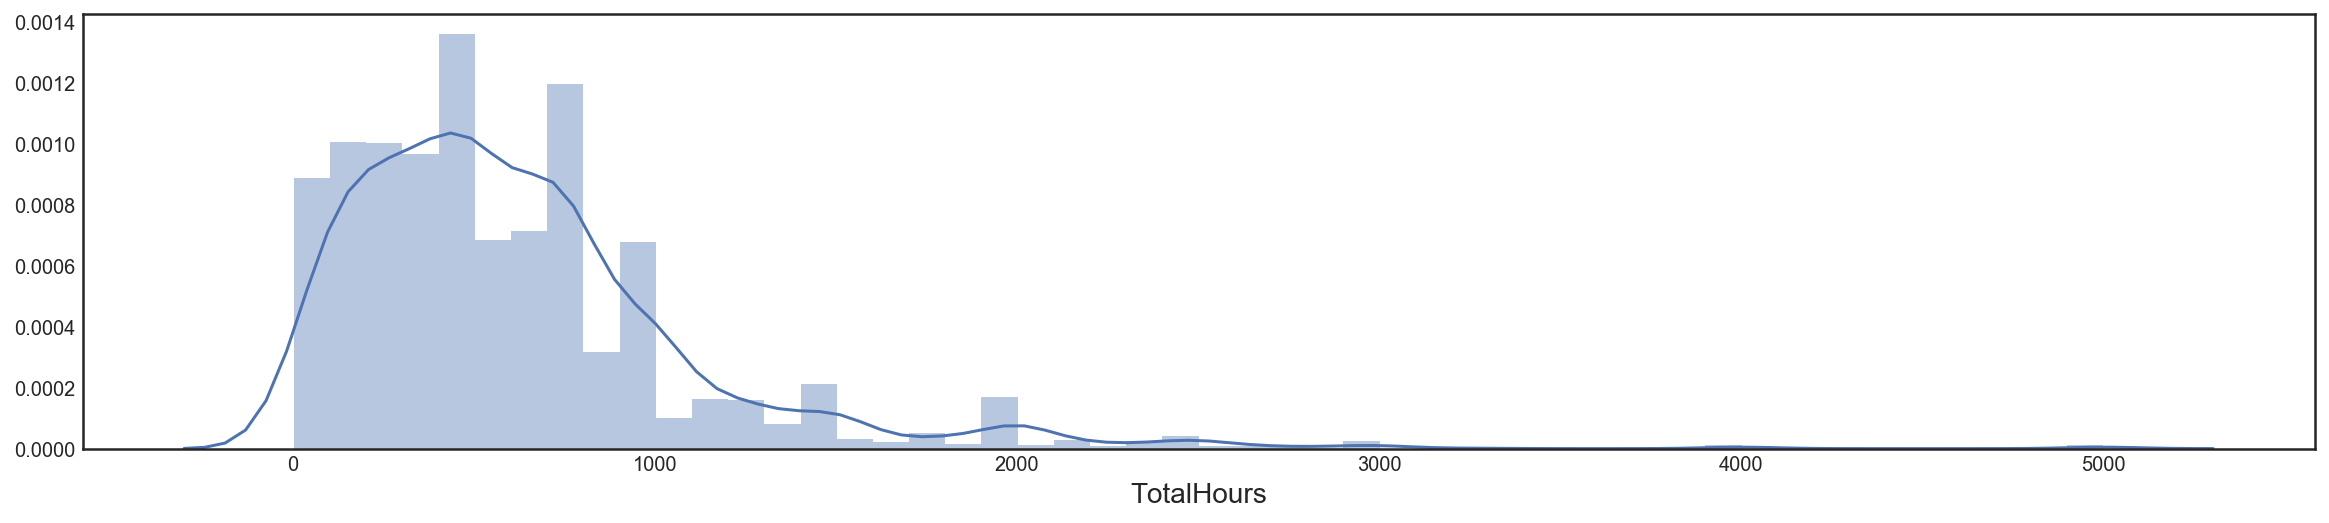

In [15]:
sFraser_ds = pd.read_csv('../../../resource-datasets/starcraft/SkillCraft1_Dataset.csv')
plt.figure(figsize=(20,4))
_ = sns.distplot(sFraser_ds['TotalHours'].apply(lambda x: np.nan if x == '?' or int(x) > 5000 else int(x)).dropna())

Using the median value of 500 total hours we get a lowbal estimate of 4.3 billion hours collective hours spent on StarCraft 2.
    
### SC2 - the skillset
Broadly speaking, the game requires the following skills:
- Macro (the ability to build a thriving economy capable of supporting the ever escalating cost of the army).
- Micro (the ability to command units in a way that far outclasses their default performance under the game's AI).
- Scouting (players are only able to see things in the vecinity of their units - scouting the oponent is an absolute nessesity)
- Strategy (the ability to build a synergistic economy/army that is well suited to confront the enemy's strategy).
- The ability to do all these things at once.

### SC2 - the races and their units

As mentioned above, players can choose one of 3 races to comand, these are:

- Terrans (Space humans)
- Zergs (Space insects)
- Protoss (Space wizards)

Each have their own units, buildings, technologies and playstyles.

In reducing the state of the game to a collection of features it will become aparent that the game state is entirely determined by:

    The game vesion.
    The map and its current state.
    The units, buildings and technologies in play.

We concentrate for now on the units each race has at its disposal. 

We've agregated several information sources into the following table:

In [16]:
unit_attributes_df = pd.read_pickle('./Resources/unit_attributes.p')
unit_attributes_df.sample(3,random_state=4)

,Unit,Mineral,Vespene,Supply,Build Time,Build From,Life,Shields,Energy,Armor,Race,Flying
4,Ghost,200,100,2,40,Barracks,100,0,200,0,Terran,False
20,Zergling,50,0,1,24,Larva,35,0,0,0,Zerg,False
54,Adept,100,25,2,38,Gateway,80,70,0,1,Protoss,False


Of the two currencies used to train units, vespene gas is a tougher resource to obtain, with a player's gas income very rarely eceeding 25% that of their mineral income.

As a rule of thumb, more expensive units are better, but a mid tier unit early in the game can often be better value than a delayed top tier unit, and many low tier units may close a game if used effectively during the first minutes of a match.

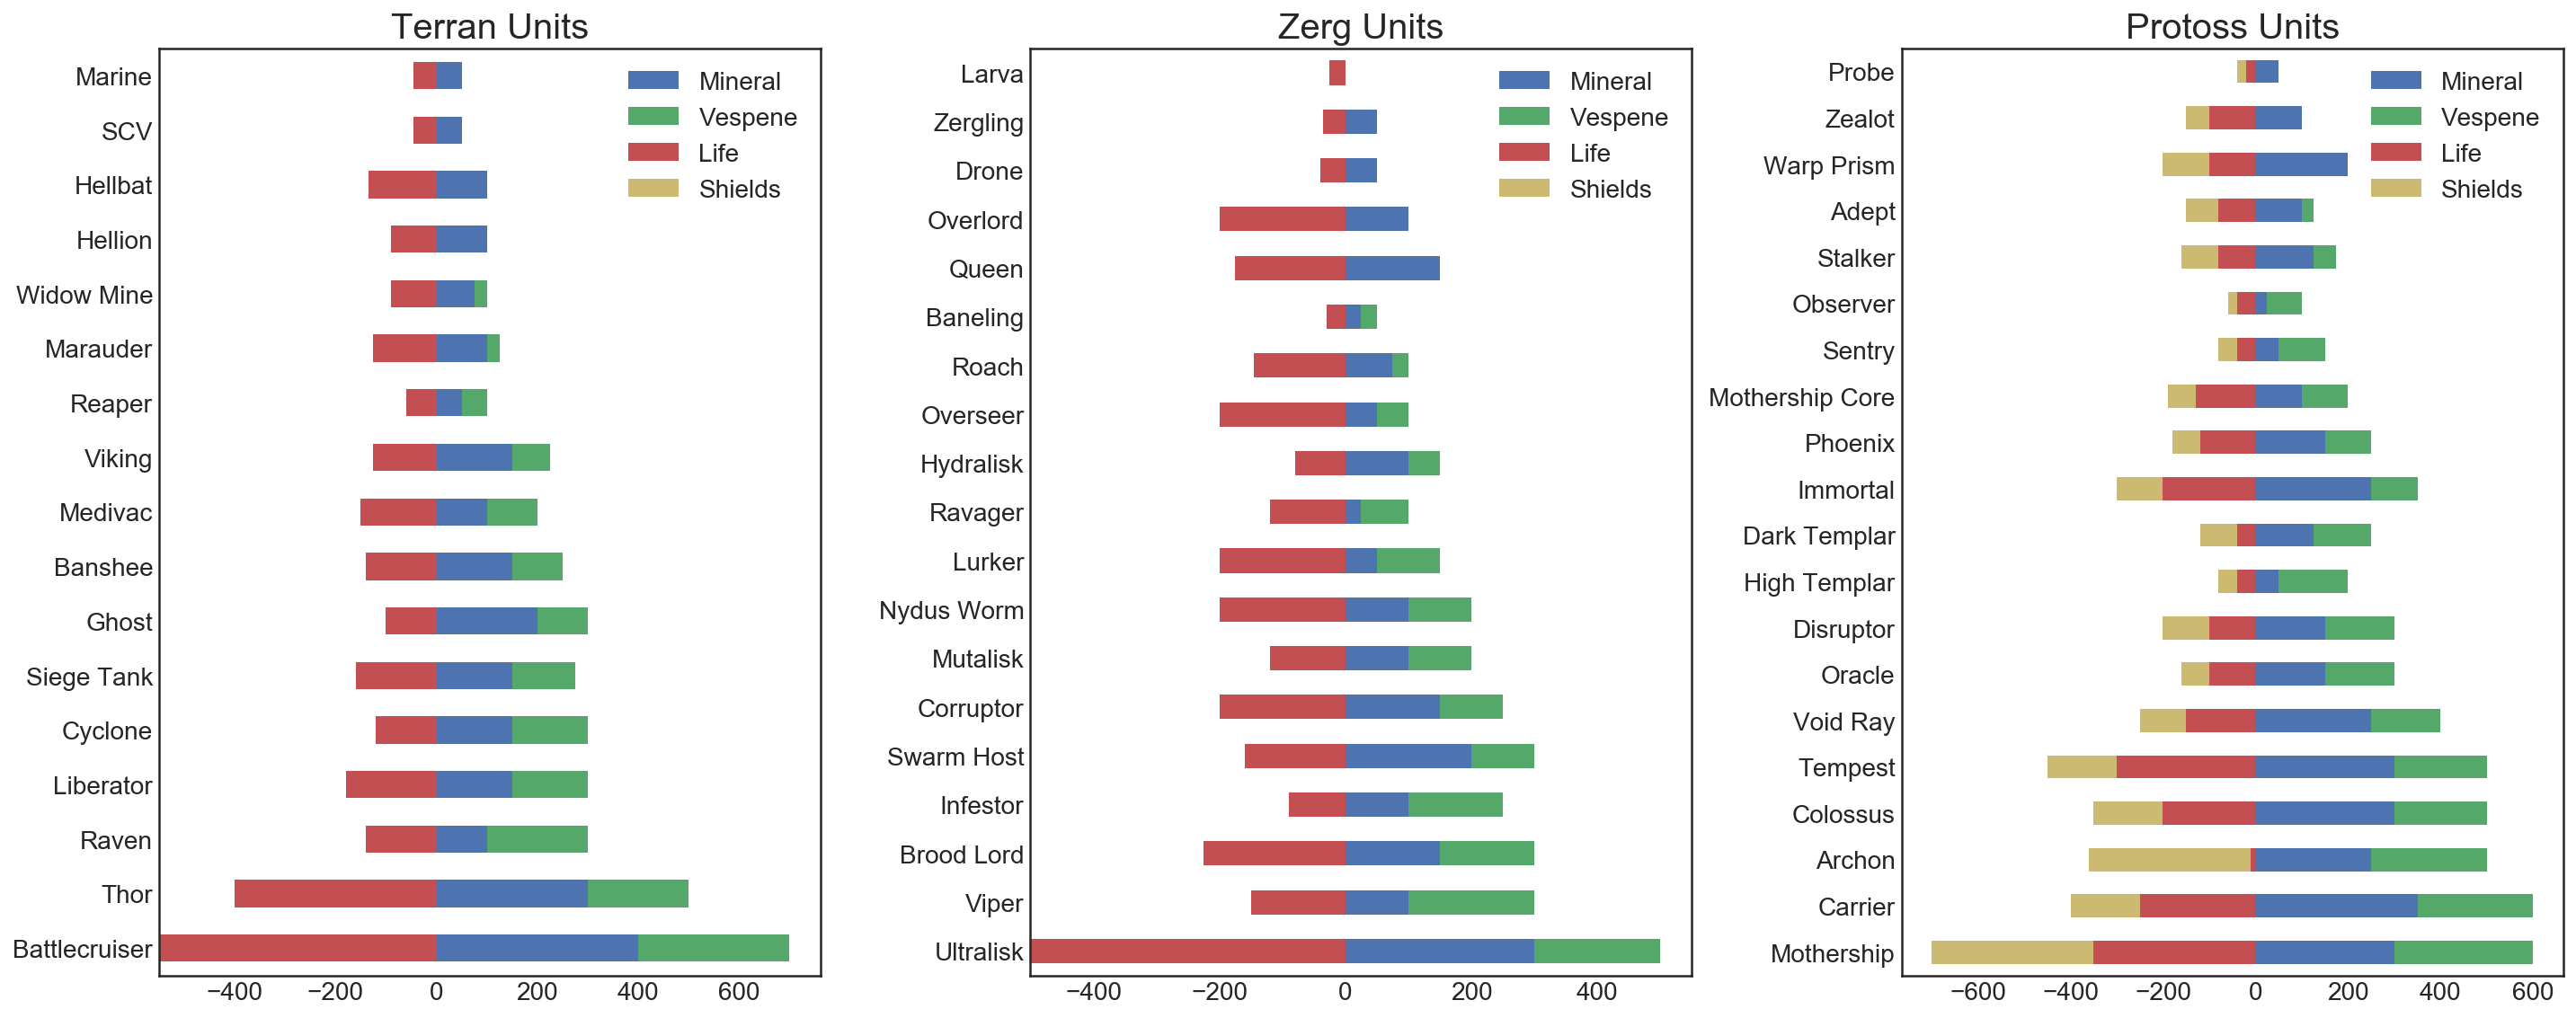

In [17]:
df = unit_attributes_df.sort_values(by = ['Vespene','Mineral'], ascending = False)
df[['Life','Shields']] = df[['Life','Shields']].applymap(lambda x: -x)
fig, axes = plt.subplots(nrows=1, ncols=3)

races = ['Terran','Zerg','Protoss']
for i,race in enumerate(races):
    df[df['Race'] == race][
        ['Unit','Mineral','Vespene','Life','Shields']
    ].plot(x = 'Unit',kind='barh',figsize=(20, 8), 
           fontsize = 14,
           stacked= True, ax = axes[i])
    axes[i].set_ylabel('')
    axes[i].set_title(race + ' Units',size= 20)
plt.tight_layout(w_pad=1)
plt.show()


<a id='Acquiring initial data'></a>

## Exploring the replay file format
> Spectator modes are no longer an afterthought, but a core feature touted throughout the development process.
<br>
<br>
><div style="color:gray ; text-align: left">_Twitch_ - 2013 Retrospective</div>

One of the key features that led to the succes of SC2 as an eSport has been the ease with which games can be shared. SC2 is a purely deterministic game, meaning that a game is described fully by the actions of its human players. Hence, unlike other games for which the only avenue of sharing is a video file of the game, SCII manages to store the full content of a 20minute match in just a over 100kb.

The Starcraft II replay format was developed internally by Blizzard Entertainment and contains all the nessesary information for the game engne to display a facsimile of the match - namely the initialization conditions of the game and the individual actions (clicks, selections, key-presses and camara movements) initiated by the players.

We are very grateful to the developers of the python library sc2reader for their work in parsing the hexadecimal .SC2replay files into a tracktable python object, and to Blizard entertaiment for including (as of relese 2.0.8) information in the replay file that is not nessesary for the game engine to reproduce the game but essential to our analysis. 

In [18]:
path_to_games = './../../../sc2games/'
example_gamefile = path_to_games + 'Dark_v_INnoVation-AbyReef.SC2Replay'
replay = sc2reader.load_replay(example_gamefile)
type(replay)

sc2reader.resources.Replay

For the purposes of this project it is not nessesary for the reader to fully familiarize themselses with the sc2reader.resources.Replay class. It is sufficient to make the following observations:

- most game events are logged with a reference to the 'frame' they happed in.
- the replay has 16 frames to every 1 game-second.
- games are usually played at 1.4x speed.
- players are themselves objects, each of which contain several attributes, one of which is the list of units that were under their command at any point of the game.
- units themselves are objects with further attributes, such as their time of creation, their name and their owner.
- all player actions are logged (clicks, selections, keystrokes, camara movements, etc) but not all outcomes (StarCraftII is a deterministic game, hence only human actions are nessesary to recreate the game). 
- both player actions and game outcomes fall under the broad category of 'event'.
- each event is an object, often of a specific subclass.
- Regarding everything: assume it's an object containing further objects (or list of objects) as attributes.

##### A closer look at events

As mentioned above, the replay file is esentially a parsed log of all events that transpired in the game. Some event types are much more common than others and some are more relevant than others for our purpose at hand. All together there are 24 event types:

In [19]:
event_types = {event.name for event in replay.events}
plist(event_types)

GetControlGroupEvent            SetControlGroupEvent            UnitPositionsEvent              
UnitDoneEvent                   UserOptionsEvent                UnitInitEvent                   
PlayerSetupEvent                UnitOwnerChangeEvent            TargetUnitCommandEvent          
DataCommandEvent                UnitDiedEvent                   SelectionEvent                  
CameraEvent                     BasicCommandEvent               UnitBornEvent                   
UnitTypeChangeEvent             TargetPointCommandEvent         AddToControlGroupEvent          
PlayerStatsEvent                PlayerLeaveEvent                ProgressEvent                   
ChatEvent                       UpdateTargetUnitCommandEvent    UpgradeCompleteEvent            


which collectively are described by 140 attributes. 

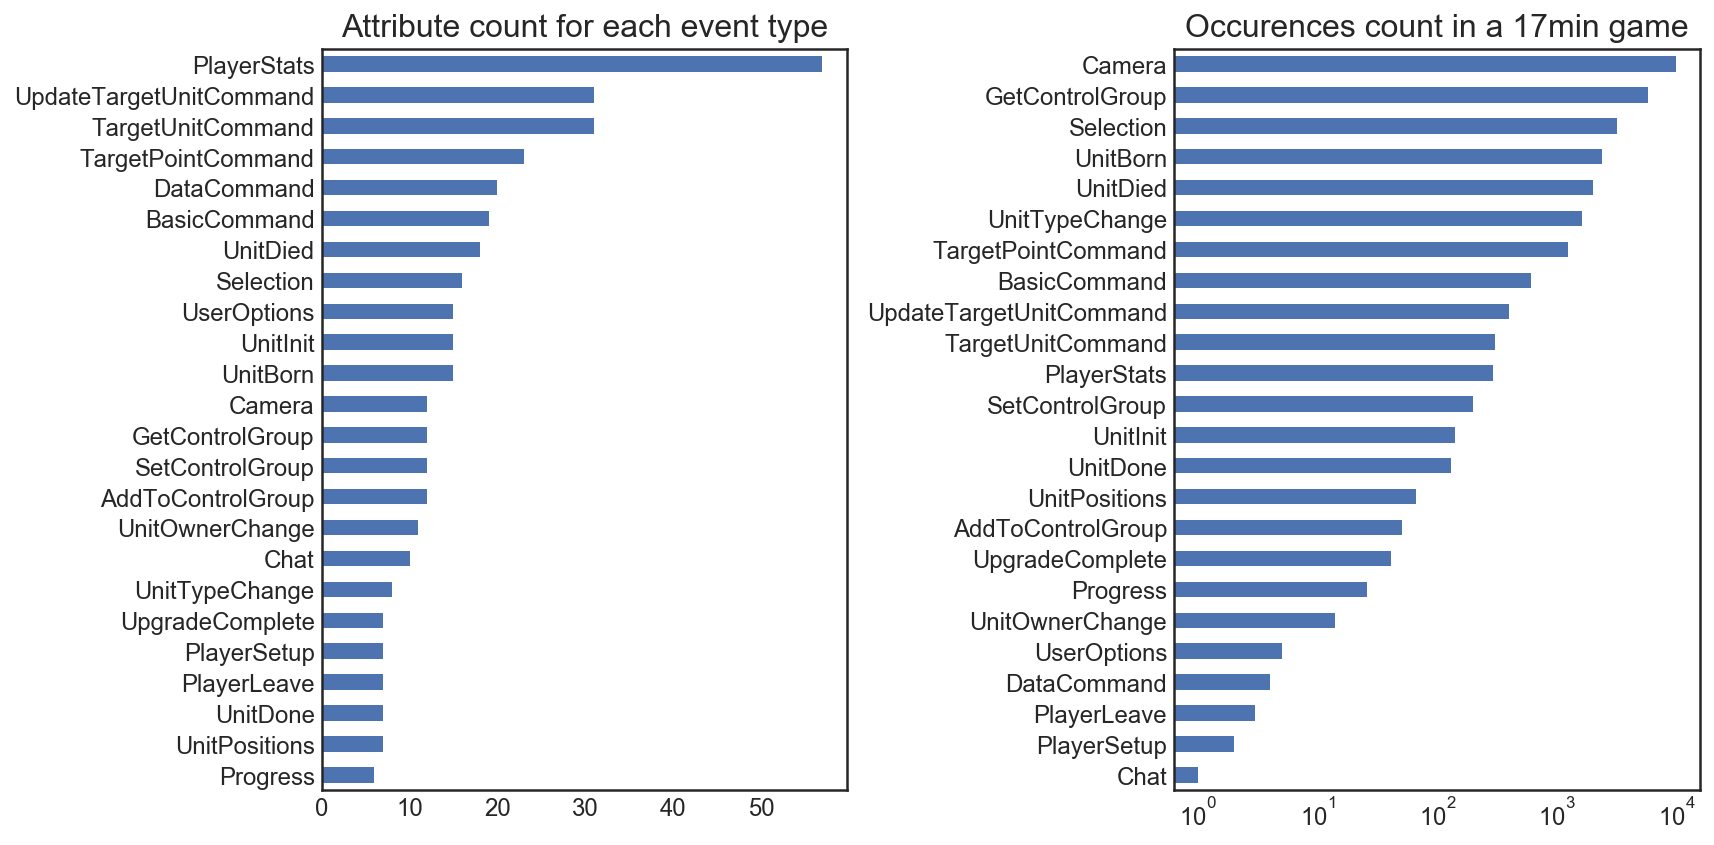

In [20]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
pd.Series({event.name[:-5]: len(list(event.__dict__.keys()))
           for event in replay.events}
         ).sort_values().plot(kind='barh', fontsize=12)
plt.title(s = 'Attribute count for each event type', size = 16)

plt.subplot(1,2,2)
event_occurence_count = pd.Series([event.name[:-5] for event in replay.events]
                                 ).value_counts(ascending = True)
event_occurence_count.plot(kind='barh', logx = True, fontsize=12)
plt.title(s = 'Occurences count in a 17min game', size = 16)

plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

One natural place to start is to look at the PlayerStats events and the information it contains.

In [21]:
def getEvents(name = '', replay = None):
    return list({event for event in replay.events if name in event.name})

In [22]:
df = pd.DataFrame([{key:event.__dict__[key] for key in event.__dict__.keys()
              if key not in ['stats','name','player','frame']} for event in getEvents(name='PlayerStats',replay=replay)])
df = df[[col for col in df.columns if 'ff_' not in col]].sort_values(by = 'second')
df.columns = [col.replace('food', 'supply').replace('pid', 'player_id') for col in df.columns]
df['second'] = df['second'].apply(lambda x:x/1.4)

print('Relevant attributes of the PlayerStats event class:\n{}'.format('='*79))
plist(list(df.columns), col_num=2)

Relevant attributes of the PlayerStats event class:
supply_made                                      supply_used                                      
minerals_collection_rate                         minerals_current                                 
minerals_killed                                  minerals_killed_army                             
minerals_killed_economy                          minerals_killed_technology                       
minerals_lost                                    minerals_lost_army                               
minerals_lost_economy                            minerals_lost_technology                         
minerals_used_active_forces                      minerals_used_current                            
minerals_used_current_army                       minerals_used_current_economy                    
minerals_used_current_technology                 minerals_used_in_progress                        
minerals_used_in_progress_army                   minerals

At this time we do not wish to delve into this information in too much detail - primarely because we will deduce most of these features from other aspects of the replay file, and partly because they contain hardly any infromation of importance (for predictiong the winner) when considering a game in isolation. 

All the same - there is no harm in pressenting the change of these features over time and their intercorrelation. 

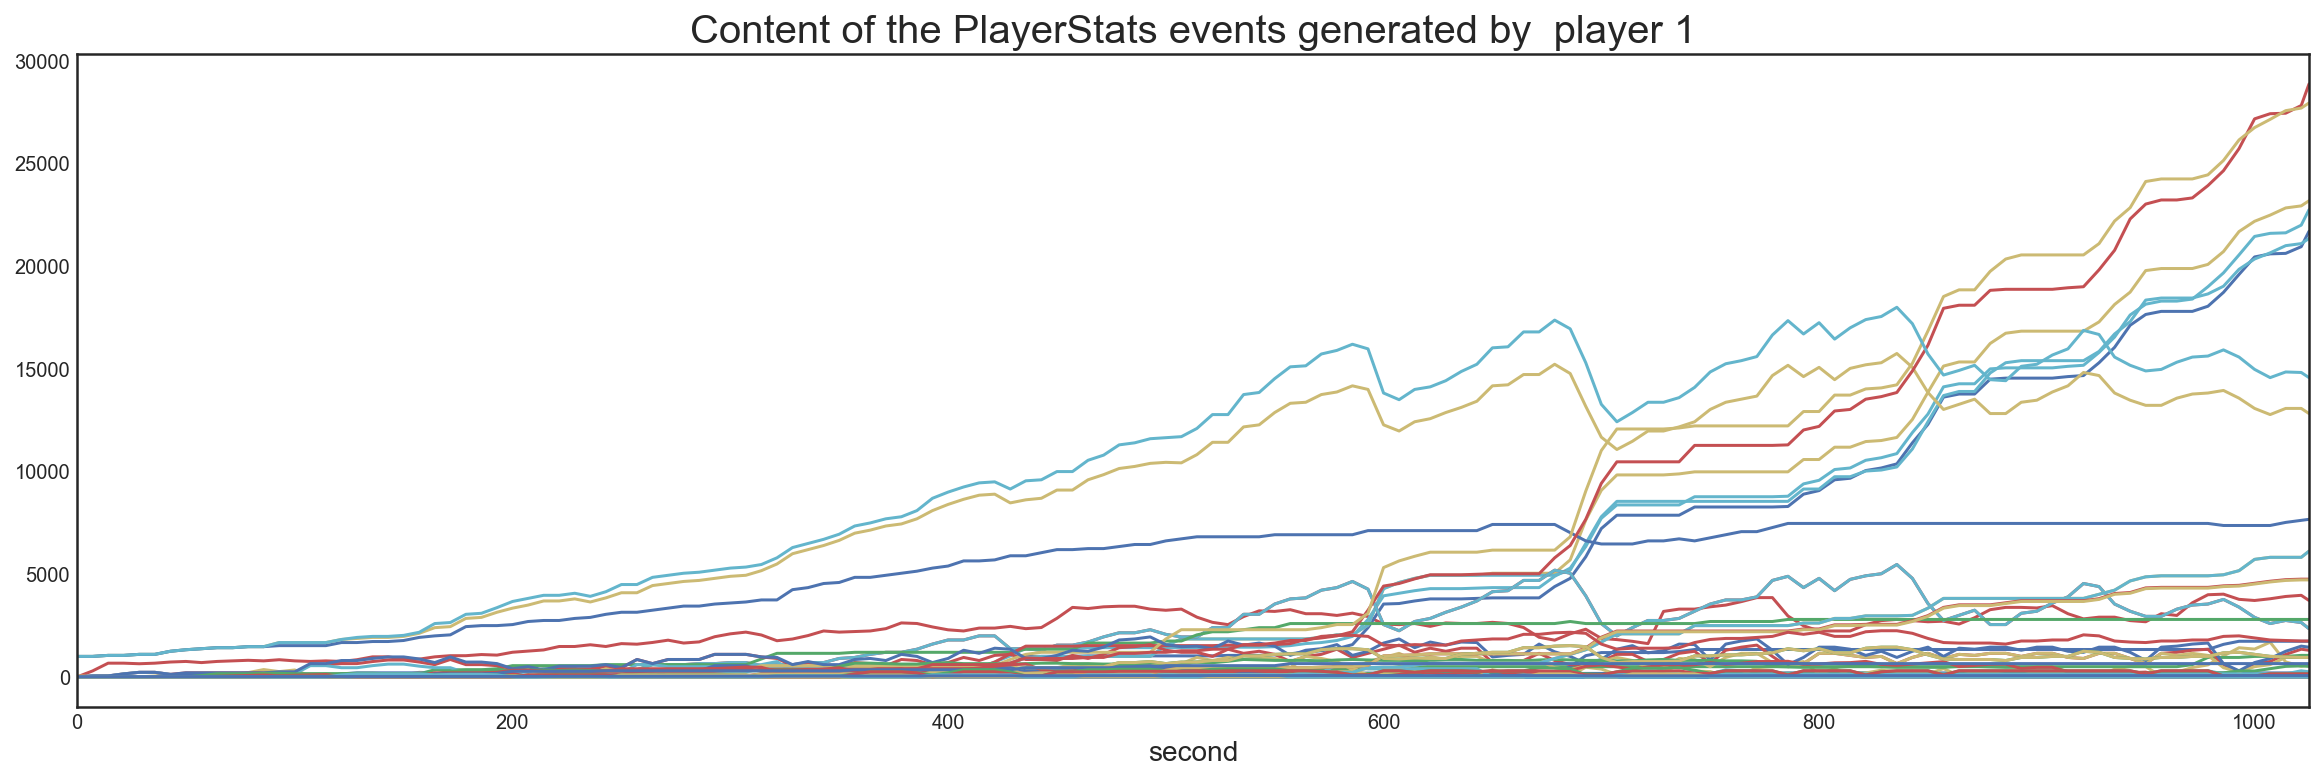

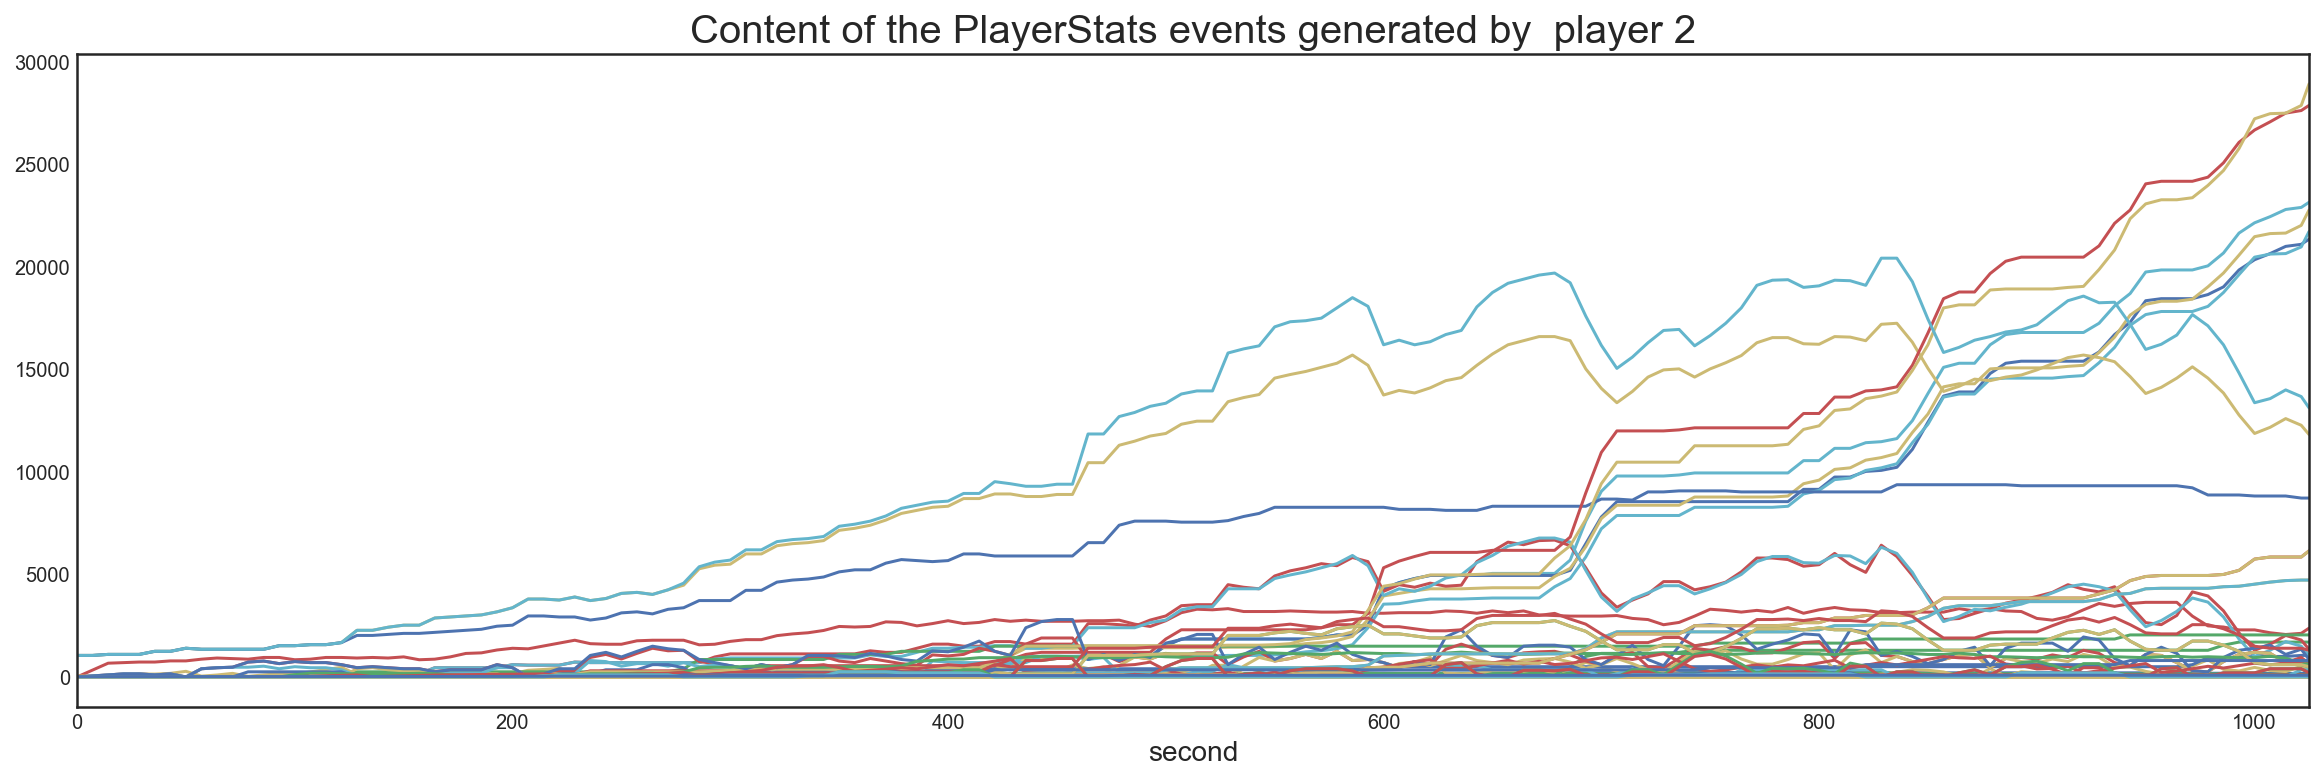

In [23]:
plot_1, plot_2 = df.groupby('player_id').plot(figsize=(20,6),x='second', legend=False)
plot_1.set_title('Content of the PlayerStats events generated by  player 1', fontsize=20)
plot_2.set_title('Content of the PlayerStats events generated by  player 2', fontsize=20)

It is particularly interesting to look a heatmap representation of the correlation between these features. It is particularly interesting to see this correlation change minute to minute, and - in particular - as the game approaches its end.

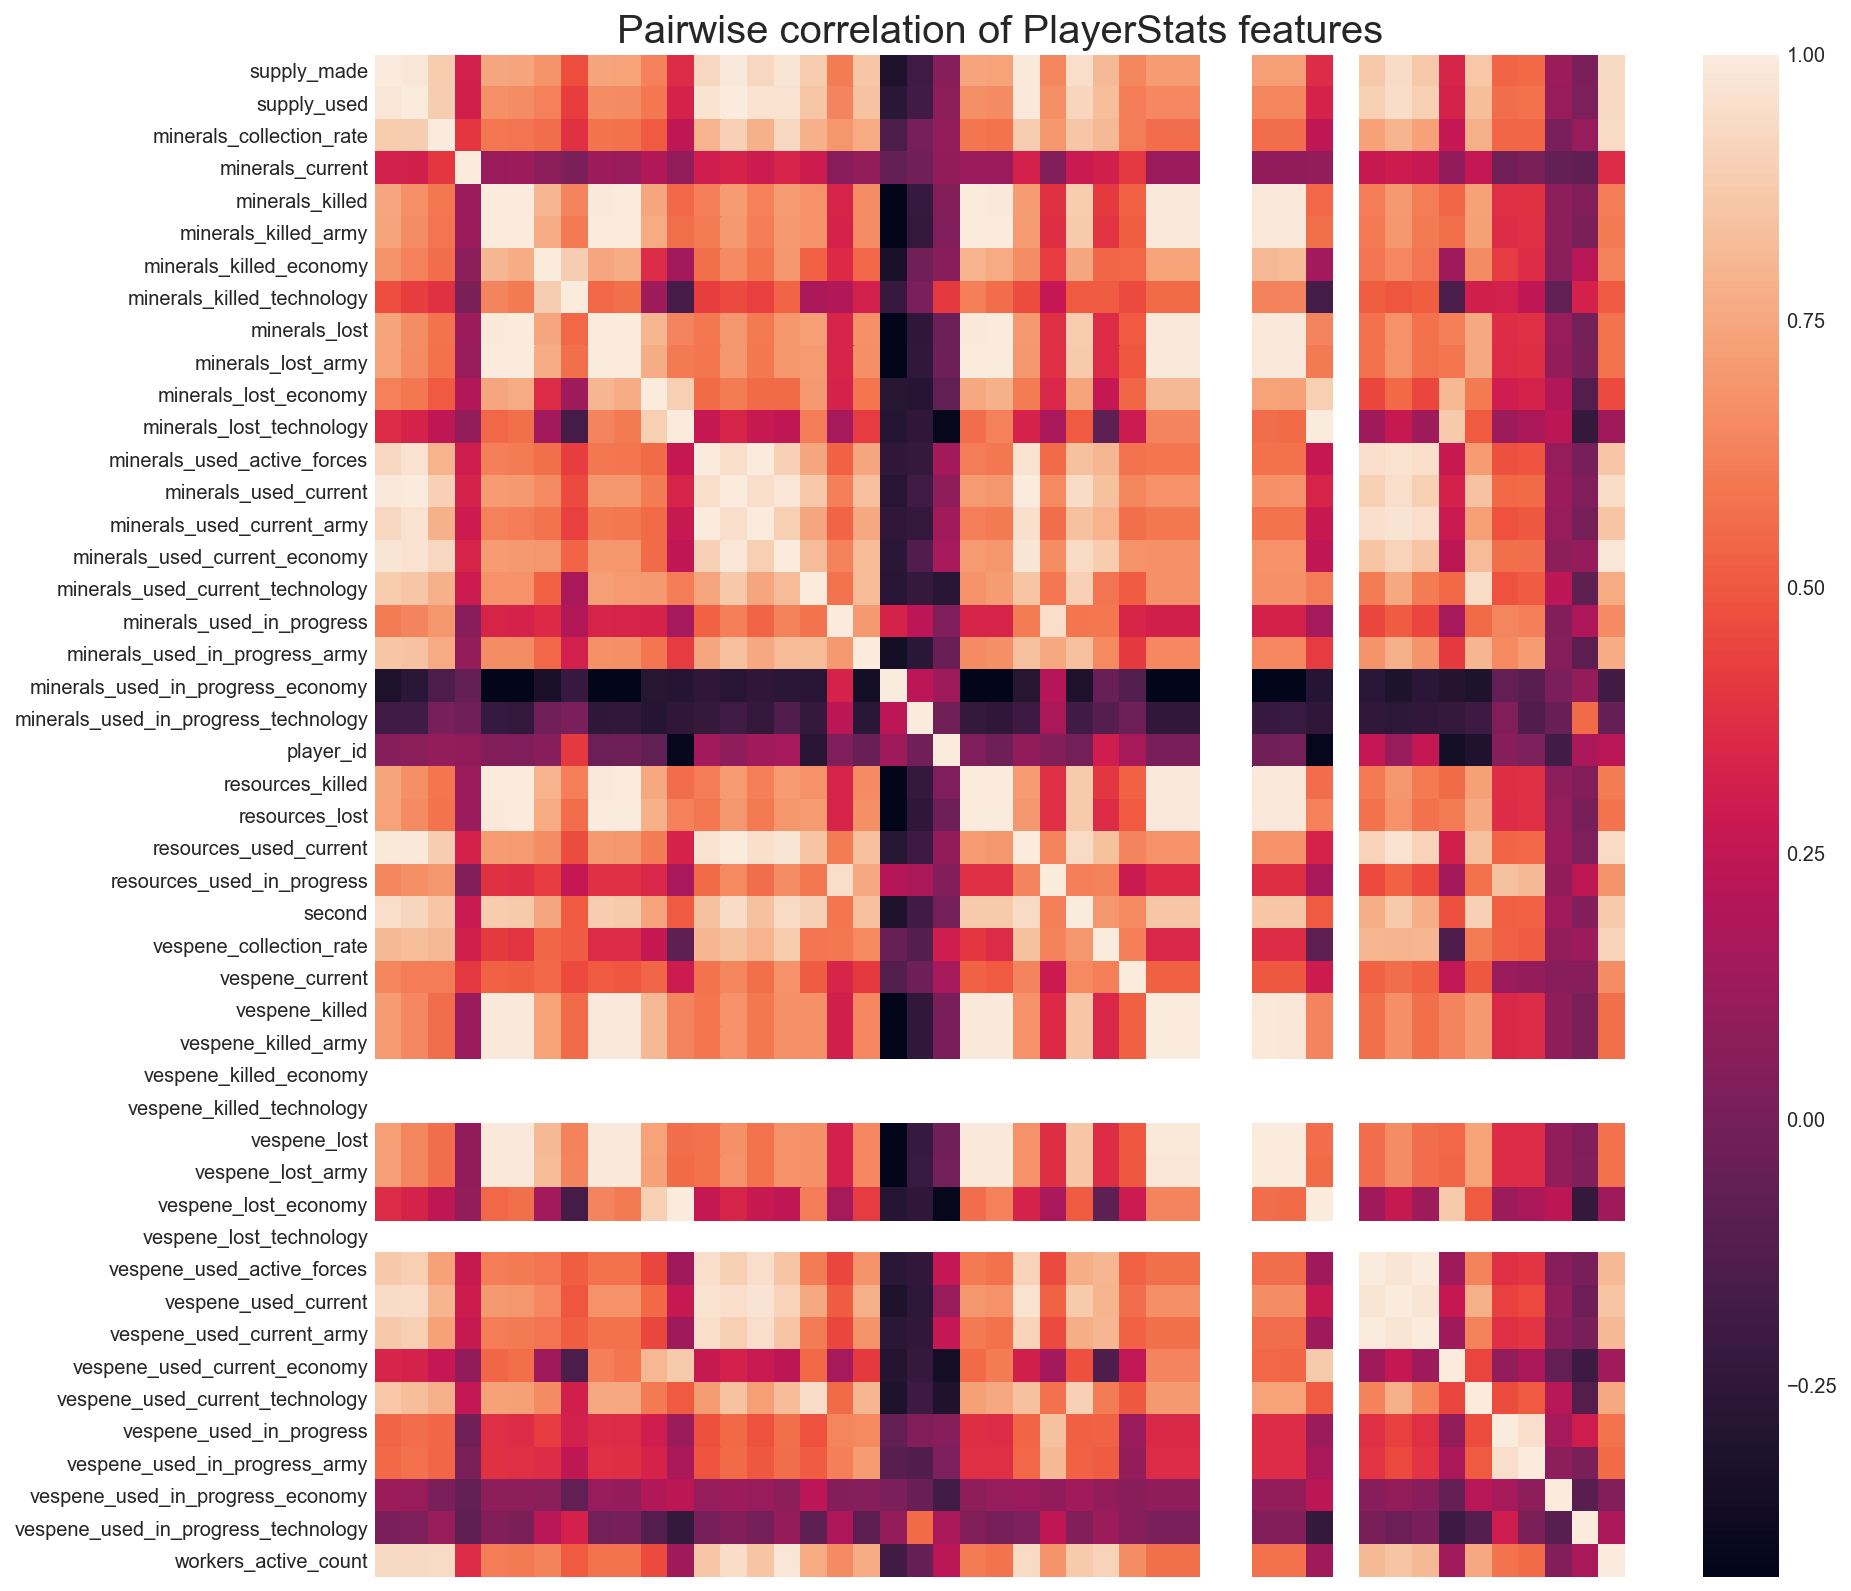

In [24]:
plt.figure(figsize=(14,14))
sns.heatmap(df[df['second'] <= df['second'].max()-60].corr(), cbar = True, xticklabels=False)
plt.title('Pairwise correlation of PlayerStats features')

Perhaps one of the most interesting observations we can make with regards to the plot above - aside from noting that some attributes have constant values througout the match - is that there are only fairly weak correlations between the player_id and other fields, and that the few correlations we observe can be interpreted as merely reflecting player_1's choice of spending more on technologies, causing him to spend more vespene gas on the whole. However, we will return to this heatmap once we have agregated data from several games, and by relabeling the winner player_1 any correlation we observe between player_id and the other features will become significantly more interesting.

Another aproach will be to look at the correlation between these features on a rolling window of time. Below is are the resulting plots we obtain with a 3 minute window on the current game.

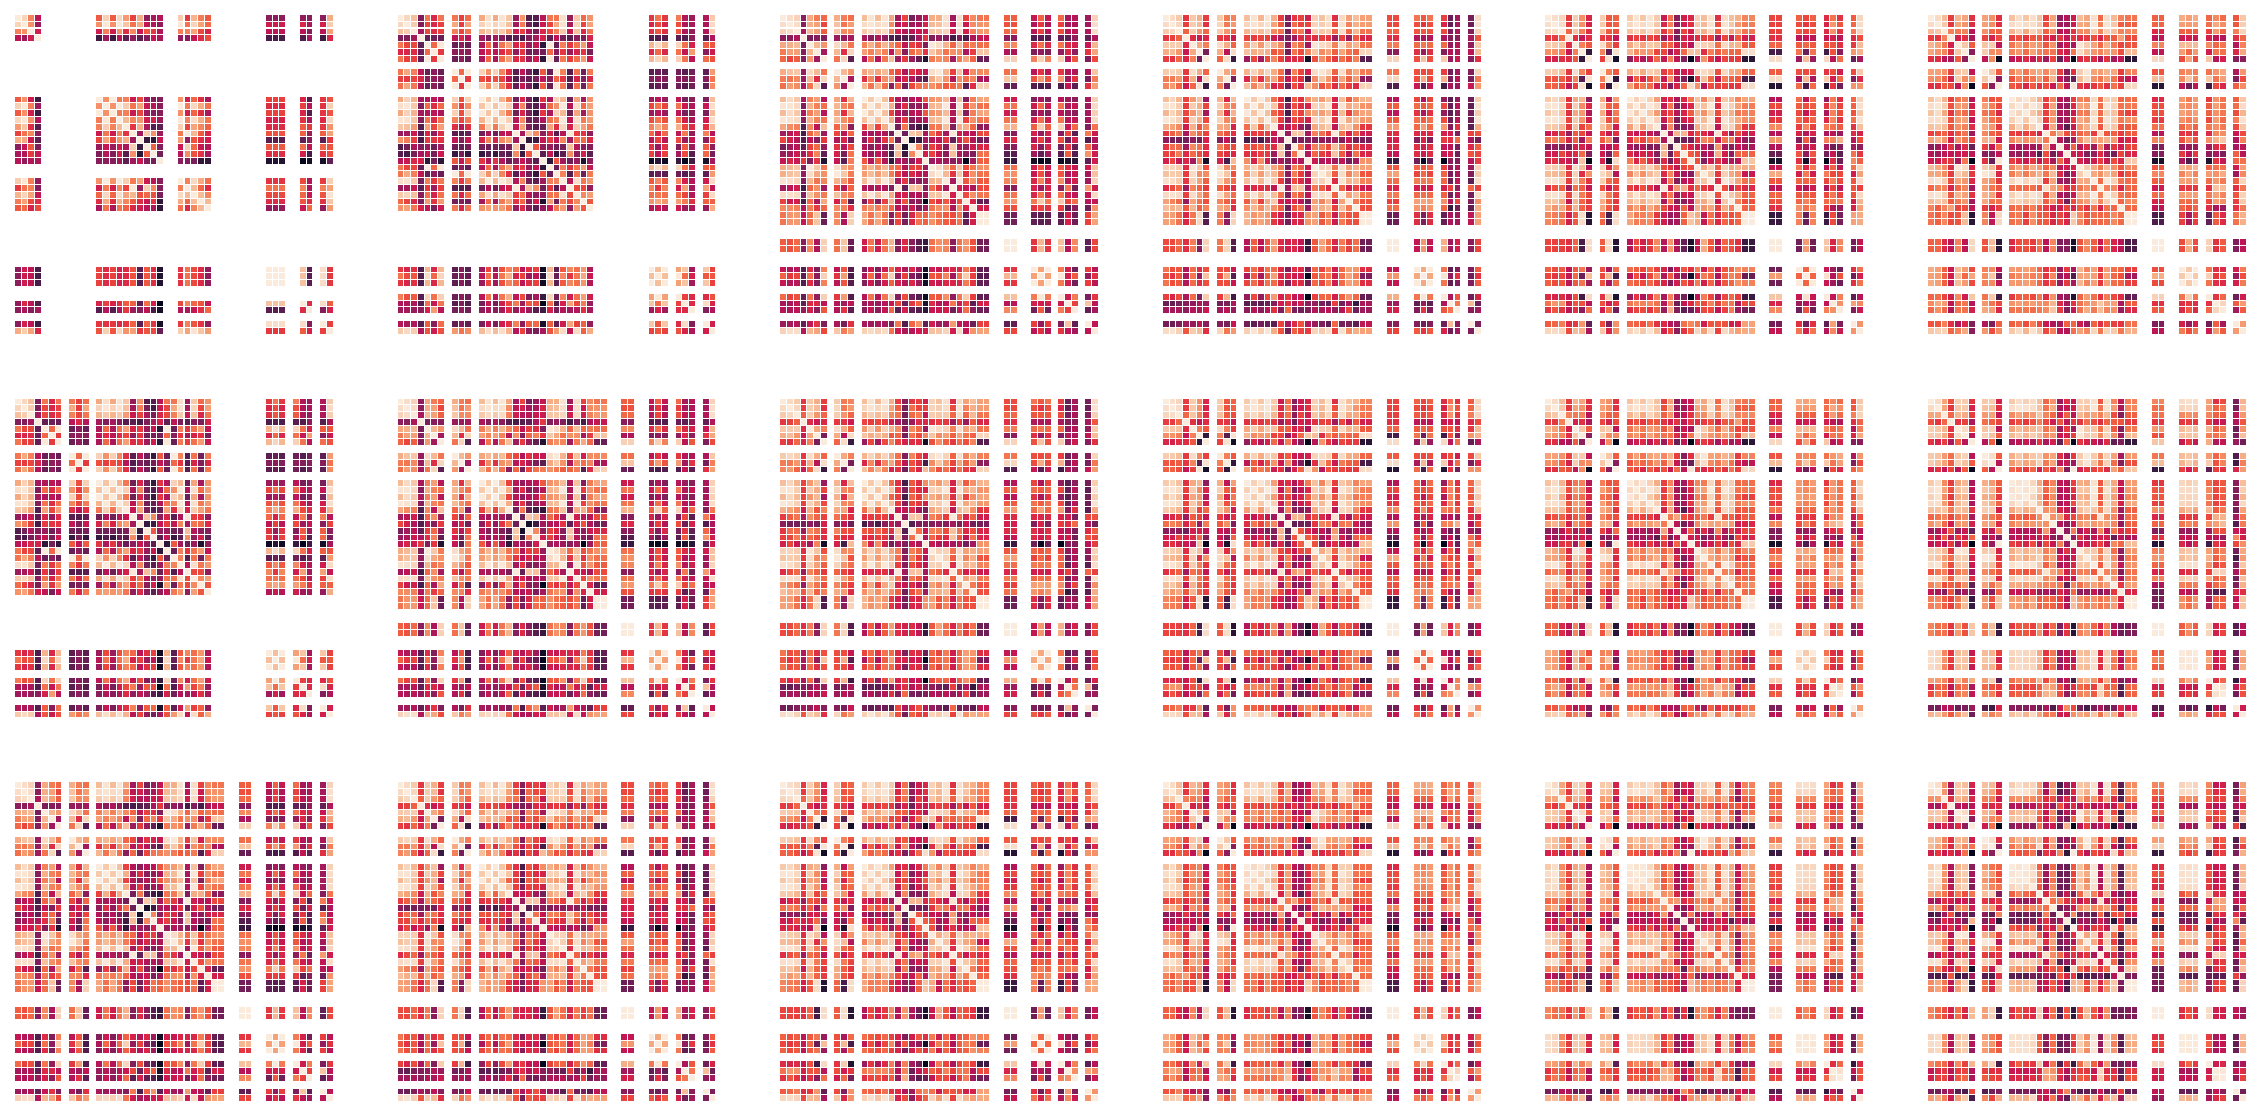

In [25]:
def heatmap_of_game_stats_plotter(data,axes, minute = 0, i = 0, j = 0):
    data_during_minute = data[data['second'] <= minute*60 + 90]
    data_during_minute = data_during_minute[data_during_minute['second'] > minute*60 - 90]
    try:
        sns.heatmap(data_during_minute.corr(), cbar = False, xticklabels=False,yticklabels=False, ax=axes[i,j], linewidths=0.01)
    except:
        sns.heatmap(data_during_minute.corr(), cbar = False, xticklabels=False,yticklabels=False, ax=axes[j], linewidths=0.01)
        
fig,axes = plt.subplots(nrows=3, ncols=6, sharey=True, figsize= (20,10))
for i in range(3):
    for j in range(6):
        heatmap_of_game_stats_plotter(df, axes, minute=i+j+1,i=i, j=j)

Lastly, it will also be interesting to visualize the state of the winning player and loosing player in the minutes leading up to player_2 conceeding the match.

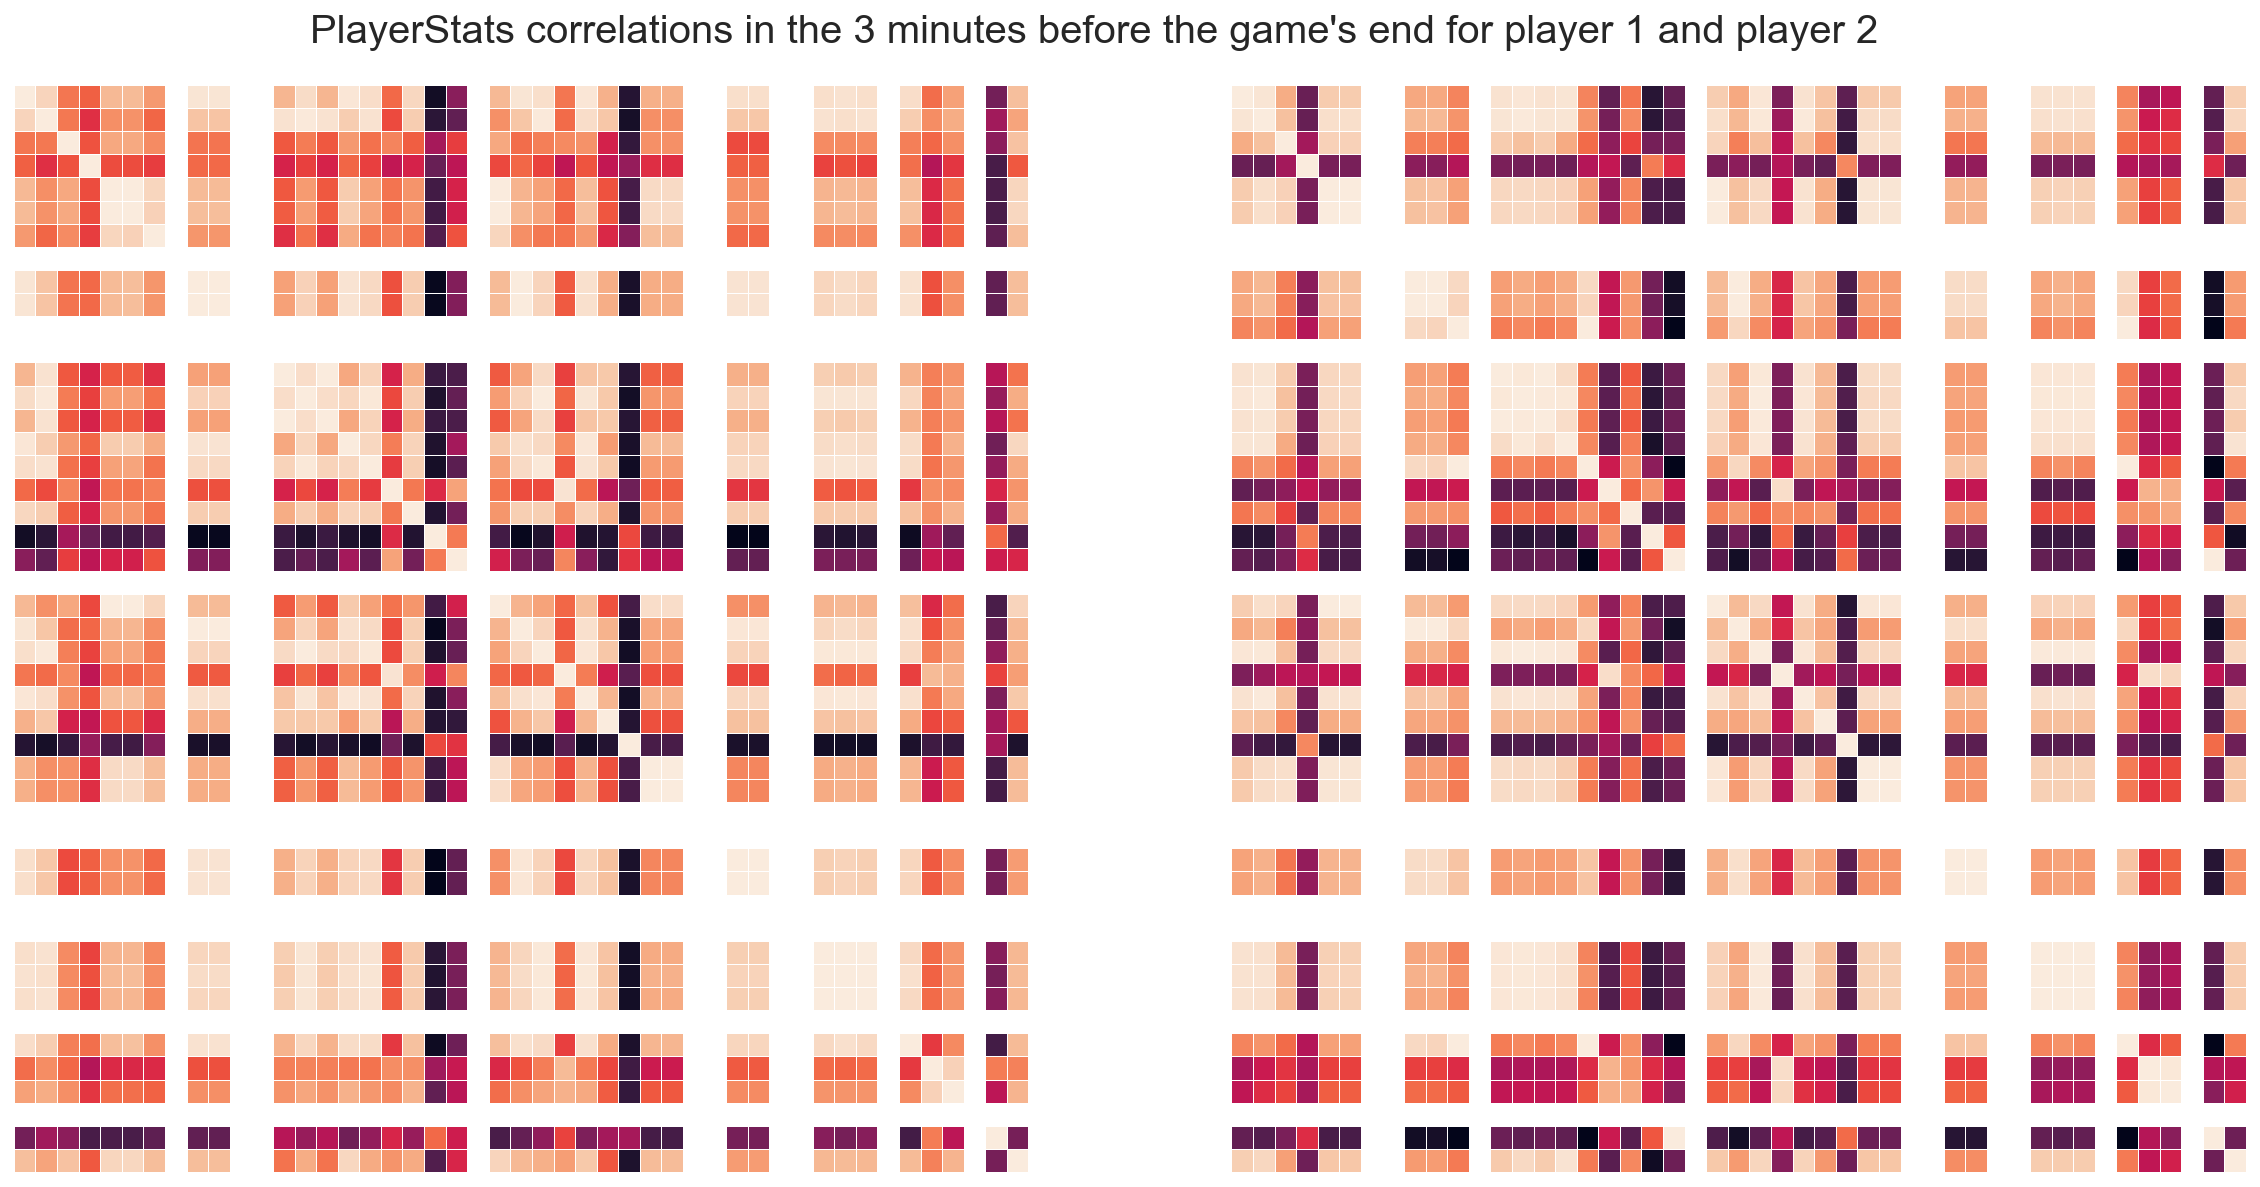

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize= (20,10))
plt.suptitle('PlayerStats correlations in the 3 minutes before the game\'s end for player 1 and player 2', fontsize=20, y = 0.93)
heatmap_of_game_stats_plotter(df[df['player_id'] == 1], axes, minute=i+j+1,i=0,j=0)
heatmap_of_game_stats_plotter(df[df['player_id'] == 2], axes, minute=i+j+1,i=0,j=1)

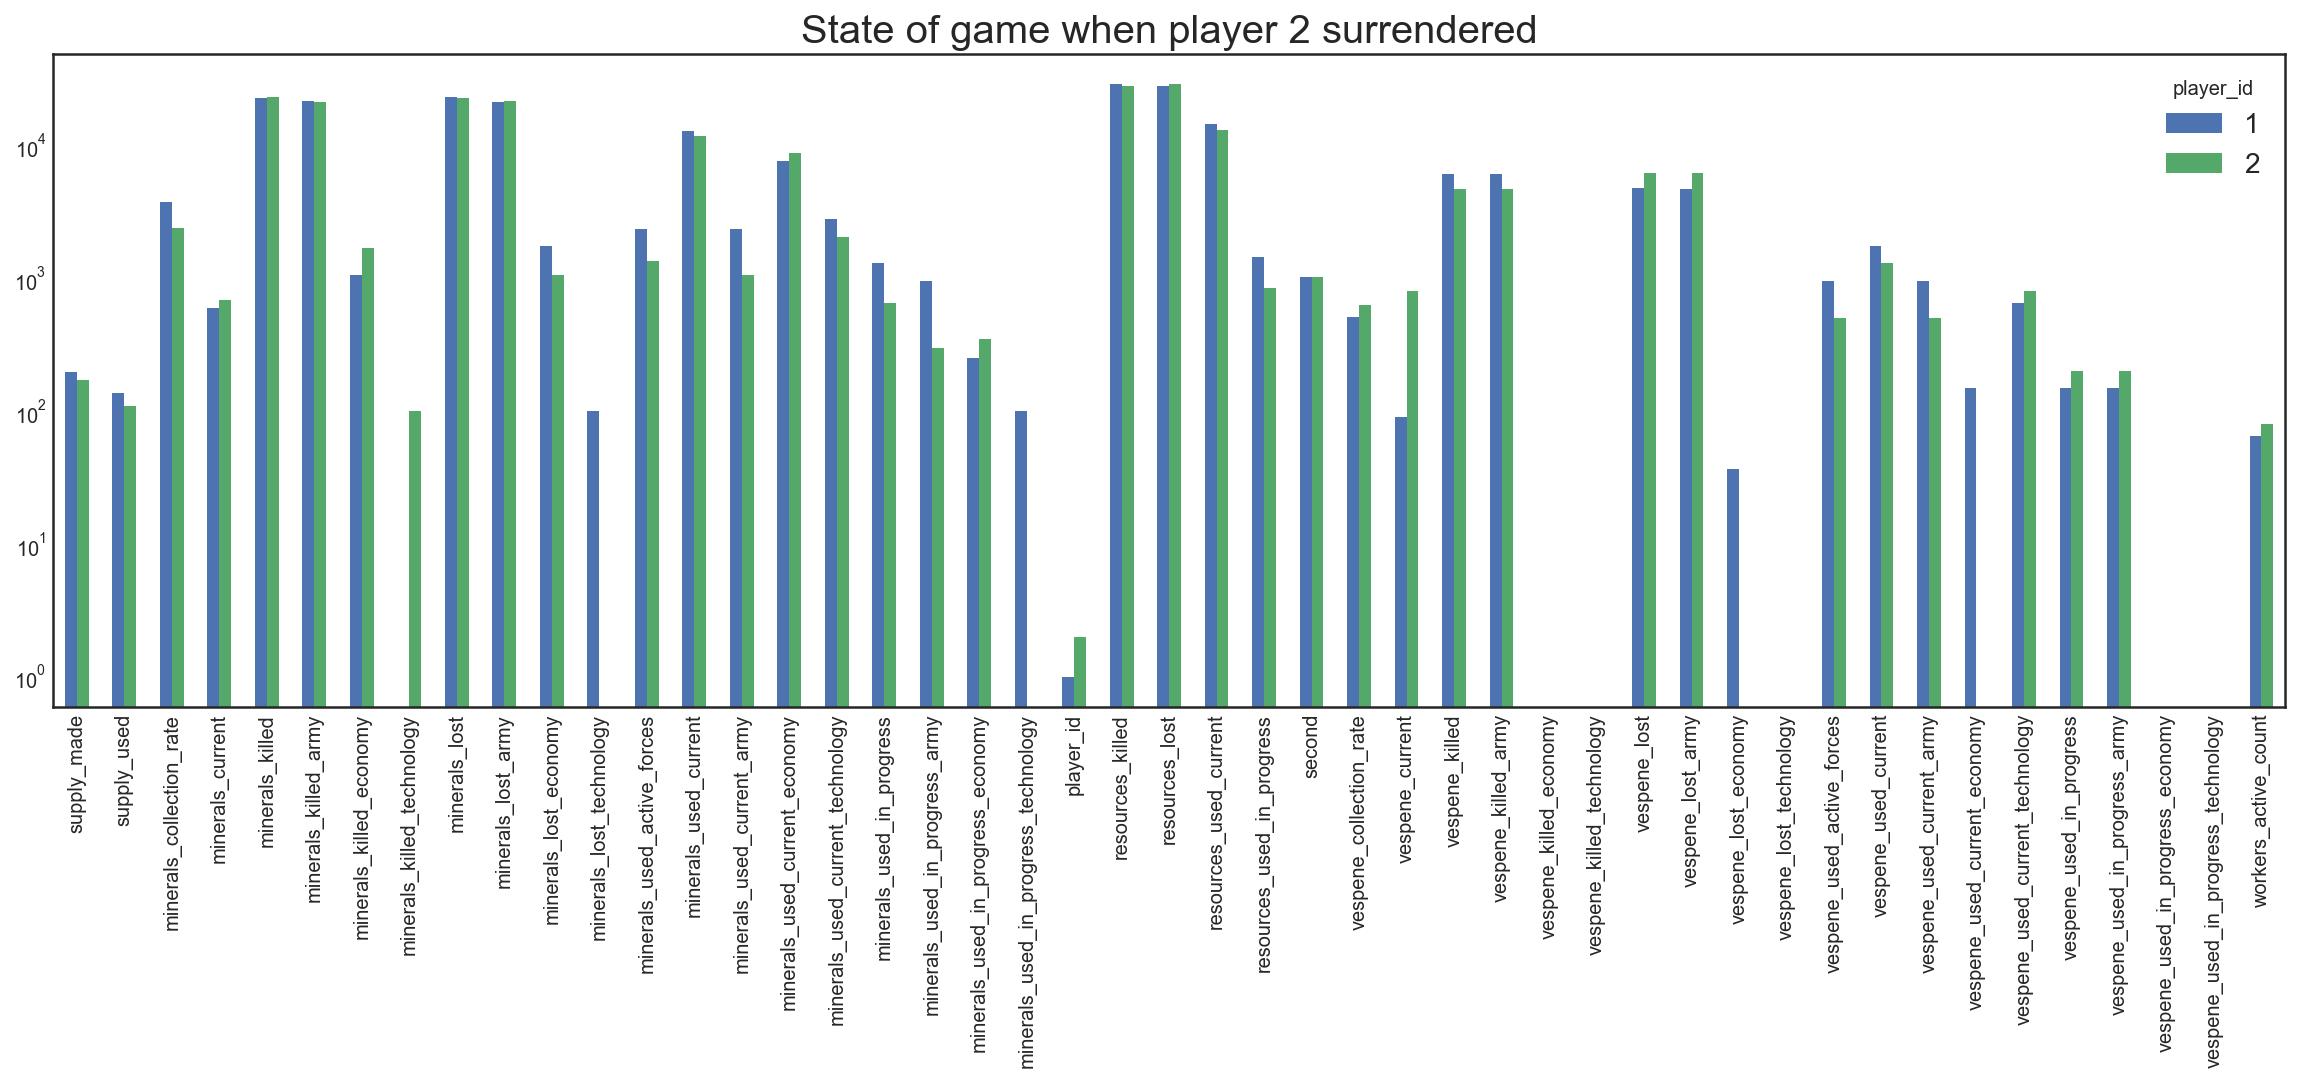

In [27]:
player_stats_when_game_ended = df[df.second == 1025].drop_duplicates()
player_stats_when_game_ended.index = player_stats_when_game_ended.player_id
player_stats_when_game_ended.sort_index(ascending=True, inplace=True)
player_stats_when_game_ended.T.plot(kind = 'bar', stacked = False, legend = True, figsize=(20,6), logy=True, title='State of game when player 2 surrendered')

We conclude our examination of these features with the reiteration of our intent to examin them further once we have agregated data from several games.

However, we conceive of the game's state as being almost entirely captured in the information pertaining to the units in play. As we shall see, a somewhat detailed portrait of the game state may be obtained by looking exclusively at the unit objects for each player.

##### A closser look at units

All starcraft 2 units, their names, images, properties, and other features can be found at this [link](http://us.battle.net/sc2/en/game/unit/).

Units in our replay file contain several attributes of interest, namely:

    name
    owner
    started_at
    finished_at
    died_at
    location
    is_army
    is_worker
    is_building
    
Sadly, many other properties are not included in the replay file's unit objects. Features such as:

    Flying
    Speed
    Invisible
    etc...
   
However, the inclusion of all of these features into a tabular representation of the game state may be misguided. Note that these values will be precisely a linear combination of the tallies for the various units at play. This may be perfecly valid form models such as SVM's or random forest, but would cause significant issues if blindly passed to a linear model.
    
our desire to easily querry the replay file for units based on these features motivate the following:

In [28]:
def frames_to_irl_seconds(num): 
    return (num/16) / 1.4

def irl_seconds_to_frames(num): 
    return num * 16 * 1.4

def getUnits(units = [], time = False,
             finished_before = np.inf, finished_after = 0,
             died_before = np.inf, died_after = 0, 
             army = True, workers = True, buildings = True,
             player = None, name = None,replay = None):
    
    if type(time) != bool:
        died_after = time+1
        finished_before = time
    
    died_before = irl_seconds_to_frames(died_before)
    died_after = irl_seconds_to_frames(died_after)
    finished_before = irl_seconds_to_frames(finished_before)
    finished_after = irl_seconds_to_frames(finished_after)

    if player != None:
        units = player.units
    elif units == []:
        units = replay.players[0].units + replay.players[1].units
    else:
        units = units
        
    return [unit for unit in units 
            if (unit.finished_at != None and 
                unit.finished_at <= finished_before
                and unit.finished_at >= finished_after)
            
            and (unit.died_at == None 
                 or unit.died_at >= died_after)
    
            and (died_before == np.inf or (unit.died_at != None
                 and unit.died_at <= died_before))
            
            and ((unit.is_army and army) 
                 or (unit.is_worker and workers)
                 or (unit.is_building and buildings))
            
            and (name == None or name in unit.name)]

In [29]:
def getUnitFeatures(features = [], kwargs = {}):
    units = getUnits(**kwargs)
    
    attributes = [feature for feature in features if feature not in ['player_id','unit']]
    df = pd.DataFrame({feature: [unit.__getattribute__(feature) for unit in units] for feature in attributes}, 
                      columns=features)
    
    df.applymap(lambda x:np.nan if x == None else x)
    
    for col in list(set(df.columns) & set(['started_at','died_at', 'finished_at'])):
        df[col] = df[col].apply(frames_to_irl_seconds).apply(lambda x:int(x) 
                                                             if np.isnan(x) == False 
                                                             else np.complex('j'))
    
    special_features = [feature for feature in features if feature in ['player_id','unit']]
    if 'player_id' in special_features:
        try:
            df['player_id'] = [unit.owner.pid for unit in units]
        except:
            df['player_id'] = [unit.owner for unit in units]
            
    if 'unit' in special_features:
        df['unit'] = units
    return df

Exampe usage:

In [30]:
getUnits(name='Hellion', replay = replay)

[Hellion [4180003],
 Hellion [3F00007],
 Hellion [4940001],
 Hellion [3B40004],
 Hellion [5040003],
 Hellion [50C0002]]

In [31]:
getUnitFeatures(['name','location','minerals','vespene','finished_at','died_at','is_army','player_id','unit'], 
                kwargs={'replay':replay, 'name':'Hellion'})

,name,location,minerals,vespene,finished_at,died_at,is_army,player_id,unit
0,Hellion,"(28, 126)",100,0,186,232,True,1,Hellion [4180003]
1,Hellion,"(29, 127)",100,0,186,233,True,1,Hellion [3F00007]
2,Hellion,"(80, 121)",100,0,210,429,True,1,Hellion [4940001]
3,Hellion,"(73, 126)",100,0,212,427,True,1,Hellion [3B40004]
4,Hellion,"(79, 123)",100,0,257,428,True,1,Hellion [5040003]
5,Hellion,"(79, 124)",100,0,257,429,True,1,Hellion [50C0002]


In [32]:
getUnitFeatures(['name','location','minerals','vespene','finished_at','died_at','is_army','player_id','unit'], 
                kwargs={'replay':replay, 'name':'Mutalisk'}).head()

,name,location,minerals,vespene,finished_at,died_at,is_army,player_id,unit
0,Mutalisk,"(149, 79)",100,100,458,740,True,2,Mutalisk [7340004]
1,Mutalisk,"(113, 32)",100,100,458,558,True,2,Mutalisk [5F80008]
2,Mutalisk,"(99, 67)",100,100,459,857,True,2,Mutalisk [6080003]
3,Mutalisk,"(148, 77)",100,100,459,739,True,2,Mutalisk [7B00002]
4,Mutalisk,"(84, 102)",100,100,459,996,True,2,Mutalisk [7DC0001]


In [33]:
def mineralValue(units):
    return sum(unit.minerals for unit in units)

def gasValue(units):
    return sum(unit.vespene for unit in units)

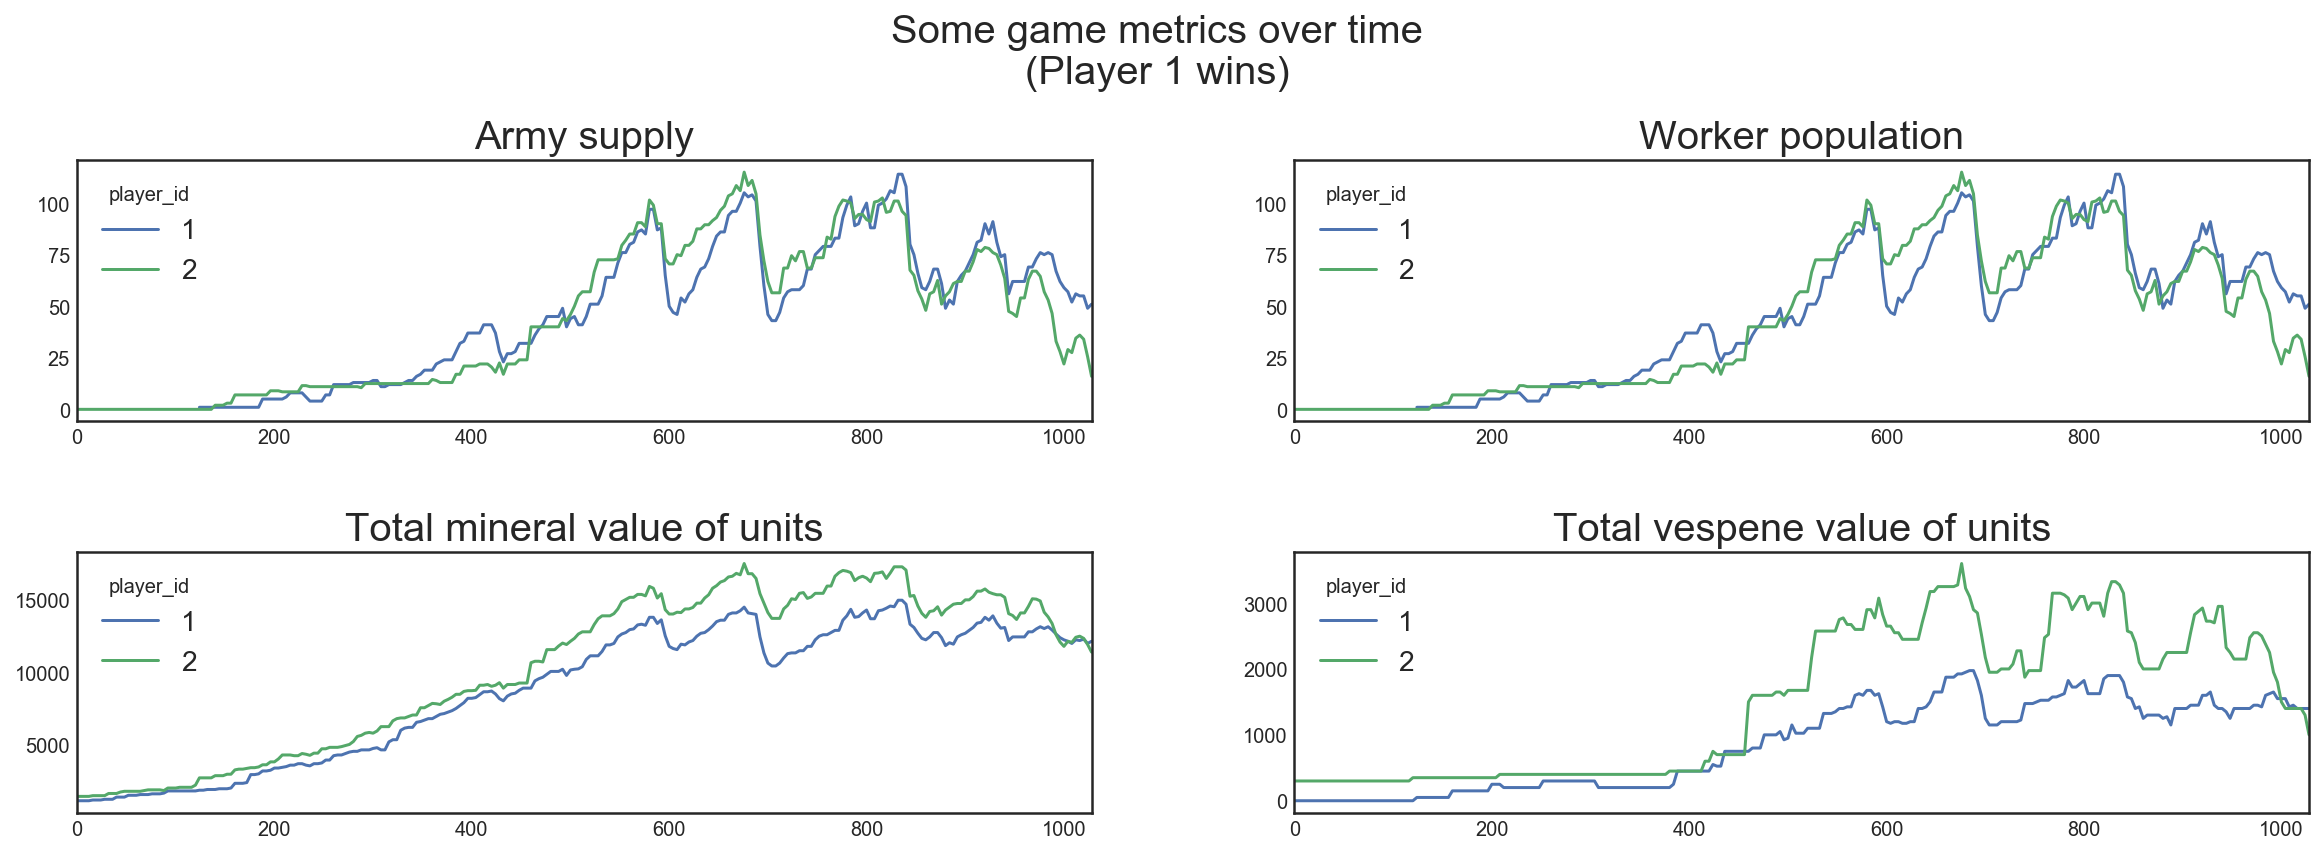

In [34]:
units_df_over_time = pd.Series(
    {t:getUnitFeatures(['supply','is_army','is_worker','minerals','vespene','player_id'],kwargs={'replay':replay, 'time':t}
                            ) for t in range(0,int(frames_to_irl_seconds(replay.frames)),4)})

army_supply = units_df_over_time.apply(lambda x:x[x['is_army'] == True].groupby('player_id')['supply'].sum())
worker_supply = units_df_over_time.apply(lambda x:x[x['is_worker'] == True].groupby('player_id')['supply'].sum())

mineral_value = units_df_over_time.apply(lambda x:x.groupby('player_id')['minerals'].sum())
vespene_value = units_df_over_time.apply(lambda x:x.groupby('player_id')['vespene'].sum())

fig, axes = plt.subplots(nrows=2, ncols=2)

army_supply.plot(ax=axes[0,0], figsize=(20,6), title='Army supply')
army_supply.plot(ax=axes[0,1], figsize=(20,6), title='Worker population')
mineral_value.plot(ax=axes[1,0], figsize=(20,6), title = 'Total mineral value of units')
vespene_value.plot(ax=axes[1,1], figsize=(20,6), title = 'Total vespene value of units')

plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Some game metrics over time\n(Player 1 wins)', size=20, y=1.05)
plt.show()

### Using unit information to visualize the game state
Plotting of game

In [40]:
def getXY(iterable):
    return [[obj[0] for obj in iterable],[obj[1] for obj in iterable]]

def getLocations(units):
    return [unit.location for unit in units]

def getUnitType(units = [], name = ''):
    return [unit for unit in units if name in unit.name]

def plotGameState(replay = None,
                 time = 0,
                 minerals = True,
                 vespene = True,
                 towers = True,
                 workers = True,
                 army = True,
                 buildings = True,
                 ramps = True,
                 kwargs = {}):
    
    kwargs['time'] = time
    
    all_units = list(replay.active_units.values())
    p1 = replay.players[0]
    p2 = replay.players[1]
    
    terran_colors = ['#0703d4','#e31a00']
    zerg_colors   = ['#a01cd9','#e00283']
    protos_colors = ['e6cf00', '#e89b00']

    classic_colors = {'Terran':terran_colors, 
                      'Zerg':zerg_colors, 
                      'Protoss':protos_colors}

    p1c = classic_colors[replay.players[0].play_race][0]
    p2c = classic_colors[replay.players[1].play_race][1]

        
    if minerals:
        mineralfields = getXY(getLocations(getUnitType(all_units, name = 'MineralField')))
        plt.scatter(mineralfields[0], mineralfields[1], color = '#44a7f2', alpha=1)
    
    if vespene:
        vespenegeyser = getXY(getLocations(getUnitType(all_units, name = 'VespeneGeyser')))
        plt.scatter(vespenegeyser[0], vespenegeyser[1], color = '#3ed121', alpha=1)
        
    if towers:  
        xelnagatowers = getXY(getLocations(getUnitType(all_units, name = 'XelNagaTower')))
        plt.scatter(xelnagatowers[0], xelnagatowers[1], color = 'k', alpha=0.5)
        
    if ramps:
        destructibleramp = getXY(getLocations(getUnitType(all_units, name = 'Destructible')))
        plt.scatter(destructibleramp[0], destructibleramp[1], color = 'orange', alpha=0.5, s = 100, marker='s')
        
    if workers:
        p1workers = getXY(getLocations(getUnits(player=p1,workers=True, army = False, buildings = False, **kwargs)))
        p2workers = getXY(getLocations(getUnits(player=p2,workers=True, army = False, buildings = False, **kwargs)))

        plt.scatter(p1workers[0], p1workers[1], color = p1c, s = 10)
        plt.scatter(p2workers[0], p2workers[1], color = p2c, s = 10)
        
    if army:
        p1army = getXY(getLocations(getUnits(player=p1,workers=False, army = True, buildings = False, **kwargs)))
        p2army = getXY(getLocations(getUnits(player=p2,workers=False, army = True, buildings = False, **kwargs)))

        plt.scatter(p1army[0], p1army[1], color = p1c, s = 10, marker='*', alpha=0.5)
        plt.scatter(p2army[0], p2army[1], color = p2c, s = 10, marker='*', alpha=0.5)
        
    if buildings:
        p1buildings = getXY(getLocations(getUnits(player=p1,workers=False, army = False, buildings = True, **kwargs)))
        p2buildings = getXY(getLocations(getUnits(player=p2,workers=False, army = False, buildings = True, **kwargs)))

        plt.scatter(p1buildings[0], p1buildings[1], c = p1c, s = 100, marker='s', alpha=0.5)
        plt.scatter(p2buildings[0], p2buildings[1], c = p2c, s = 100, marker='s', alpha=0.5)
        
    minx = min(mineralfields[0]) - 20
    maxx = max(mineralfields[0]) + 20
    miny = min(mineralfields[1]) - 20
    maxy = max(mineralfields[1]) + 20
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])

    plt.title('Map: ' + current_game.map_name + '\n'
              + 'Players: ' + current_game.players[0].name + ' / ' + current_game.players[1].name)
    plt.show()

def plwrap(time = 0, **kwargs):
    plotGameState(time=time, replay=current_game, **kwargs)
    return None

def plot_replay_of_current_game():
    current_game = replay

    interact(plwrap, time=IntSlider(min=0, max=frames_to_irl_seconds(replay.frames), step=4))
    return None

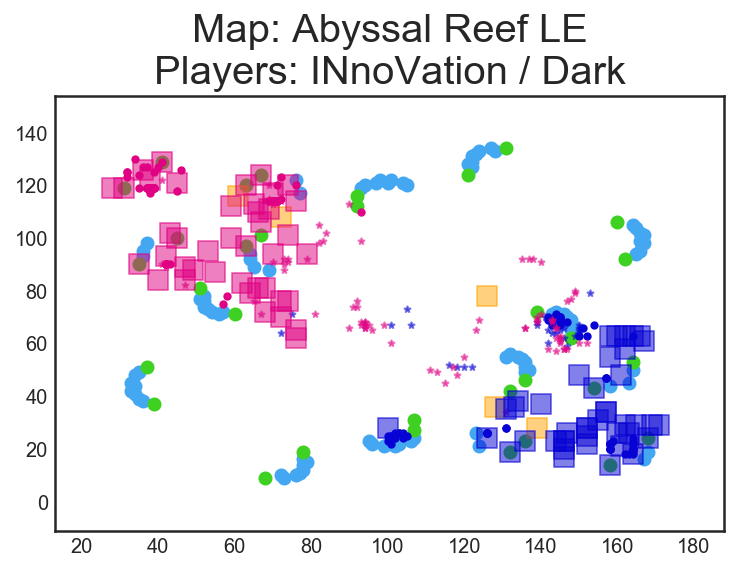

In [50]:
plwrap(time = 600)

## Analyzing a corpus of replays

A look at the Blizard server activity reveals an estimated 100,000+ competitive 1v1 games played daily, with matches lasting as little as 3 minutes or as much as 3 hours (with a mean value of 10 minutes).


### Initial data

The life cycle of our a single replay file is as follows:

    -> Game is played 
        -> Game is uploaded to one of several hosting sites
            -> We download the Replay file
                -> we use sc2reader to parse the .SC2replay file 
                    -> we use replay_to_dict 
                        -> (Feature extraction)
                            -> Tabular representation of the game state

<right><img src="./Images/Flow of Data.png" style=" margin: 15px; height: 420px"></right>


Our initial analysis will be performed on the 423 games - played by the 76 players - that took place throughout the Intel Extreme Masters (IEM) World Championship in March of 2017.

We discard 4 games that were exhibition matches btween players and the game's AI, leaving us with 419 games between humans.


### Adressing memory and loading time limitations

The 419 games (whose replay files collectively occupy 56Mb of disk space) - if parsed fully - occupy is 1.7gb of memory. 

This is may be tracktable for a few hundred games, but will severely hinder us when we seek to apply our analysis to tens of thousands of replay files.

One solution available with no further work is to set the load_level to 3 in the 

    sc2reader.load_replay() 
This amounts to not parsing the entirety of the information in the replay file, but it also cuts the time it takes to parse a .SC2replay file, (and the memory consumption of the parsed object) by 80%. Luckily we retain all the information we seek to analize.

However, this is computationaly expensive and slow - and the resulting replay file can not redily be stored. In the sister notebook

    Converting replays to dictionary.ipynb
    
we develop a function 

    replay_to_dict()

that converts the replay file into a tractable dictionary. We work with the output of this function.

In [28]:
event_types = {event.name for event in games_IEM[3].events}
plist(event_types)

PlayerStatsEvent                UnitDiedEvent                   UnitInitEvent                   
UnitDoneEvent                   ChatEvent                       ProgressEvent                   
UnitPositionsEvent              UnitOwnerChangeEvent            UnitBornEvent                   
UnitTypeChangeEvent             PlayerSetupEvent                UpgradeCompleteEvent            


<a id = 'Tabulating the data'></a>
### Tabulating the data
The replay game file as a whole is not - in its original form - tracktable by the medhods we seek to apply.

Our first goal is to build a classification model that will predict the winner based on the final game state. It is clear that the first task at hand is to reduce the state of the game to a 1 dimentional numeric array suitable to tabulation.

We continue this work in the sister notebook _Feature engineering.ipynb_

---

## Continued on "Feature engeneering.ipynb"


http://sc2rep.ru/index.php?gt=1&matchup1x1=0&tperiod=0&sort_rep=0&only_pro=on


[StarCraft II wikipedia](https://en.wikipedia.org/wiki/StarCraft_II:_Wings_of_Liberty)

[gosugames - replays](http://www.gosugamers.net/starcraft2/replays)

[gamereplays - replays](https://www.gamereplays.org/starcraft2/replays.php?game=33)

[Timeline of AI development](http://www.andreykurenkov.com/writing/a-brief-history-of-game-ai/)

[SC2 sales figures](http://www.statisticbrain.com/blizzard-entertainment-statistics/)

[Intel Extreme Masters - Largest ever eSport event](https://venturebeat.com/2017/03/16/polands-intel-extreme-masters-was-biggest-event-in-esports-history-with-173000-spectators/) 

[Ladder maps](http://wiki.teamliquid.net/starcraft2/Maps/Ladder_Maps/Legacy_of_the_Void)

[Google Deepmind takes on StarCraft II](https://deepmind.com/blog/deepmind-and-blizzard-release-starcraft-ii-ai-research-environment/)

[StarCraft II popularity in numbers](http://www.rankedftw.com/stats/population/1v1/#v=2&r=-2&sy=c&sx=a)

[Stalemate in StarCraft II](http://wiki.teamliquid.net/starcraft2/Stalemate_Detection)

[Kasparov vs Deep Blue](https://en.wikipedia.org/wiki/Deep_Blue_versus_Garry_Kasparov)